# Bayesian Optimization

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.optimize import fmin_l_bfgs_b
from sklearn.gaussian_process import GaussianProcess
import matplotlib.pyplot as plt

In [2]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


## Learning as optimization

Many learning problems can be framed as (black-box) optimization problems, for instance:

  + **Reinforcement learning/Behavior optimization**: 
    learn the parameters $\theta$ of a policy $\pi_\theta(s)$ such that some notion
    of the long-term reward/fitness $J(\pi_\theta)$ becomes maximal.
    $$\theta^* = \arg\max_\theta f(\theta) \text{ with } f(\theta) = J(\pi_\theta)$$
  + **(Hyper-)parameter tuning**: Optimizing some parameters $\theta$ of a supervised machine learning model $M$ (e.g., a deep neural net) such that some loss function $l$ on the training data $D$ is minimzed: $$\theta^* = \arg\min_\theta f(\theta) \text{ with } f(\theta) = l(M(\theta), D)$$

These examples have in common that evaluating $f(\theta)$ is typically expensive. For instance, every function evaluation in

 + behavior optimization for robotics involves a trial on the actual system
 + hyper-parameter tuning involves training a (complex) model, which is computationally often very expensive

Many black-box optimzation algorithms such as 

 + CMA-ES
 + Particle Swarm Optimization
 + Relative Entropy Policy Search (REPS)
 
are local methods, which require little computation but many function evaluations

**Bayesian optimization** is an approach which

 * tries finding $\theta^*$
 * while minimizing the number of evaluations of $f(\theta)$
 * by globally searching for the best next query point $\theta$
 * which requires considerable amounts of computation

Next: illustration of Bayesian optimization on a simple objective function

## Objective function

We want to find the maximum of a function f. Let's say $f(x) = \sin(5x)(1- \tanh(x^2))$

In [3]:
def f(x):
    return (1 - np.tanh(x**2)) * np.sin(x*5)

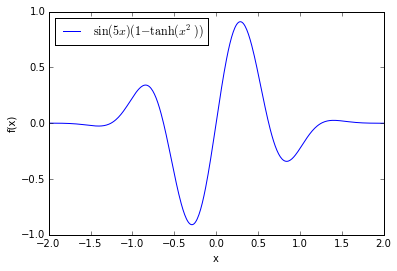

In [4]:
x = np.linspace(-2, 2, 400)[:, None]
_ = plt.plot(x, f(x), label=r"$\sin(5x)(1- \tanh(x^2))$")
plt.xlabel("x")
plt.ylabel("f(x)")
_ = plt.legend(loc='best')

Suppose we have just some samples from this function and have to decide where to sample next:

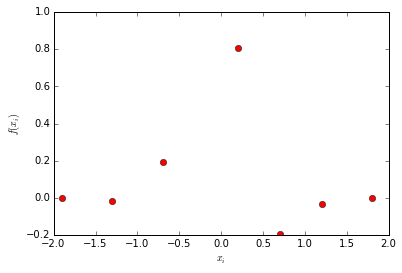

In [5]:
xi = np.array([-1.9, -1.3, -0.7, 0.2, 0.7, 1.2, 1.8])
yi = f(xi)
plt.plot(xi, yi, 'ro')
plt.xlabel("$x_i$")
_ = plt.ylabel("$f(x_i)$")

Where should we sample next?

### Modelling the unknown function

Fit a Gaussian-Process Regression model to the samples. 

This gives us a posterior distribution over possible functions that could have generated the data. 

/opt/dl/anaconda/envs/bayesopt/lib/python2.7/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class GaussianProcess is deprecated; GaussianProcess is deprecated and will be removed in 0.20. Use the GaussianProcessRegressor instead.
  warnings.warn(msg, category=DeprecationWarning)
/opt/dl/anaconda/envs/bayesopt/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function l1_cross_distances is deprecated; l1_cross_distances is deprecated and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


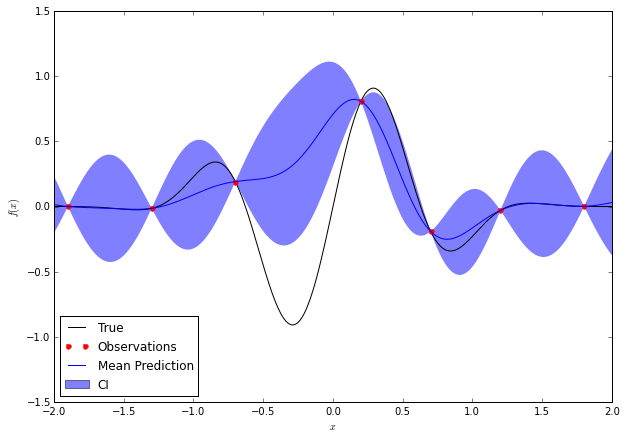

In [6]:
gp = GaussianProcess(corr='squared_exponential', 
                     theta0=0.1, thetaL=1e-2, thetaU=1e1,
                     random_start=10)
gp.fit(xi[:, None], yi)

x = np.linspace(-2, 2, 400)[:, None]
y_pred, MSE = gp.predict(x, eval_MSE=True)
sigma = np.sqrt(MSE)

plt.figure(figsize=(10, 7))
plt.plot(x, f(x), 'k', label='True')
plt.plot(xi, yi, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label=u'Mean Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.5, fc='b', ec='None', label='CI')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-1.5, 1.5)
_ = plt.legend(loc='best')


The plot shows the mean of the function distribution and the corresponding confidence interval.

Should we sample at the maximum of mean prediction? Or sample where the uncertainty is maximal?

This is essentially the exploration-exploitation trade-off.

### Acquisition functions

Acquistion functions specify which point should be sampled next. Different acquisition functions have been proposed:

Upper Confidence Bound (UCB): $\text{ucb}(x) = \mu_{GP}(x) + \kappa \sigma_{GP}(x)$
    
Probability of Improvement (PI): $\text{pi}(x) = \Phi\left(\gamma(x)\right)$
    
Expected Improvement (EI): $\text{ei}(x) = \sigma_{GP}(x)\left[\gamma(x)\Phi\left(\gamma(x)\right) + \mathcal{N}(\gamma(x); 0, 1)\right]$

with $\gamma(x)=\frac{\max(y_i) - \mu_{GP}(x)}{\sigma_{GP}(x)}$ and $\Phi$ being the cumulative distribution 
function of the normal distribution.

In [7]:
def probability_of_improvement(mu_x, sigma_x, opt_value, kappa=0.0):
    """ Returns the probability of improvement at query point x."""
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return norm.cdf(gamma_x)


def expected_improvement(mu_x, sigma_x, opt_value, kappa=0.0):
    """ Returns the expected improvement at query point x."""
    gamma_x = (mu_x - opt_value - kappa) / sigma_x
    return sigma_x * (gamma_x * norm.cdf(gamma_x) + norm.pdf(gamma_x))


def upper_confidence_bound(mu_x, sigma_x, opt_value, kappa=0.0):
    """ Returns the upper confidence point of performance at query point x. """
    return mu_x + kappa * sigma_x

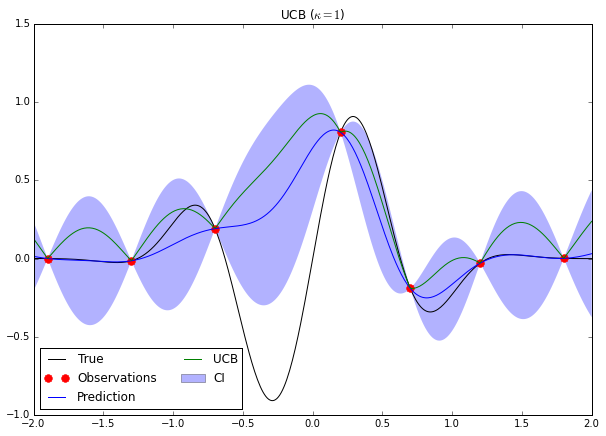

In [8]:
plt.figure(figsize=(10, 7))

ax = pylab.gca()

ax.plot(x, f(x), 'k', label='True')
ax.plot(xi, yi, 'r.', markersize=15, label='Observations')
ax.plot(x, y_pred, 'b-', label=u'Prediction')
ax.fill(np.concatenate([x, x[::-1]]),
        np.concatenate([y_pred - 1.9600 * sigma,
                       (y_pred + 1.9600 * sigma)[::-1]]),
        alpha=.3, fc='b', ec='None', label='CI')
ax.plot(x, upper_confidence_bound(y_pred, sigma, yi.max(), kappa=1.0),
        'g', markersize=10, label="UCB")
ax.set_title(r"UCB ($\kappa=1$)")
_ = ax.legend(loc="best", ncol=2)


Different acquisition functions result in different query points:

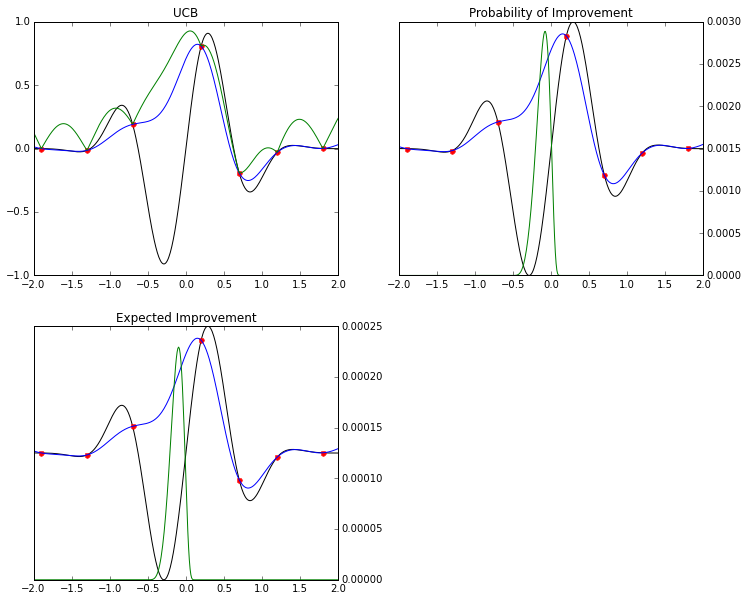

In [9]:
plt.figure(figsize=(12, 10))
for plot_id, (name, acq_fct) in enumerate([("UCB", upper_confidence_bound),
                                           ("Probability of Improvement", probability_of_improvement),
                                           ("Expected Improvement", expected_improvement)]):
    ax = plt.subplot(2, 2, plot_id + 1)
    if name == "UCB":
        ax2 = ax
    else:
        ax2 = ax.twinx()
        ax.set_yticks([])
    
    ax.plot(x, f(x), 'k', label='True')
    ax.plot(xi, yi, 'r.', markersize=10, label='Observations')
    ax.plot(x, y_pred, 'b-', label=u'Prediction')
    ax2.plot(x, acq_fct(y_pred, sigma, yi.max(), kappa=1.0 if name=="UCB" else 0.5),
             'g', markersize=10)
    ax.set_title(name)


Maximum of acquisition function cannot be computed in closed-form.

Use some black-box global optimization algorithm to find this maximum.

### Bayesian Optimization

Bayesian optimization iteratively selects points to be queried by

 + fitting a Gaussian Process model
 + defining an aquisition function
 + using an optimization algorithm to find the maximum of acquisition function

In [10]:
class BayesianOpt(object):
    def __init__(self, acquisition_function, kappa=10.0, 
                 gp_kwargs={"theta0": 1, "thetaL": 1, "thetaU": 10, 
                            "random_start": 10}):
        self.acquisition_function = acquisition_function
        self.kappa = kappa
        self.gp_kwargs = gp_kwargs
    
        self.parameters = []
        self.returns = []
        self.max_value = []
        
        self.model = None
        
    def get_next_query_point(self):
        query_point =  np.random.uniform(-2, 2)
        if len(self.parameters) >= 4:
            best_value = -np.inf
            for x0 in np.linspace(-2, 2, 10):
                res = fmin_l_bfgs_b(lambda x: -self.model.predict(x), x0,
                                     approx_grad=True, bounds=[(-2, 2)], iprint=0)
                if -res[1] > best_value:
                    best_value = -res[1]
                    query_point = res[0]
            print best_value, "\n"
        self.parameters.append(query_point)
        return query_point
    
    def set_value(self, value):
        self.returns.append(value)
        if value > self.max_value:
            self.max_value = value
        if len(self.parameters) >= 4:
            self.model = GaussianProcess(**self.gp_kwargs)
            self.model.fit(np.vstack(self.parameters), self.returns)

In [11]:
# JSAnimation import available at https://github.com/jakevdp/JSAnimation
from JSAnimation import IPython_display
from matplotlib import animation
     
opt = BayesianOpt(upper_confidence_bound)
        
fig = plt.figure(figsize=(9, 7))
ax = fig.gca()
x = np.linspace(-2, 2, 400)

def init():
    for _ in range(4):
        x0 = opt.get_next_query_point()
        func_value = f(x0)
        opt.set_value(func_value)

def animate(i):   
    mean, MSE = opt.model.predict(x[:, None], eval_MSE=True)
    sigma = np.sqrt(MSE)
    
    ax.clear()
    ax.plot(x, f(x), 'g')
    ax.plot(x, mean, 'r')
    ax.plot(x, opt.acquisition_function(mean, sigma, opt.max_value, kappa=opt.kappa), 'y')
    ax.plot(opt.parameters, opt.returns, 'bo')
    ax.plot(opt.parameters[-1:], opt.returns[-1:], 'ro', ms=10)
    ax.set_ylim(-1, 5)
    ax.set_title("Iteration: %s, Theta: %s" % (i+4, opt.model.theta_[0]))
        
    x0 = opt.get_next_query_point()
    func_value = f(x0)
    opt.set_value(func_value)
    
animation.FuncAnimation(fig, animate, init_func=init,
                        frames=1, interval=2000, blit=False)

ImportError: No module named JSAnimation

Example uses UCB with $\kappa=10$ as acquisition function